In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.append('../modules')
import ObsModels
import fun

import numba as nb

In [139]:
class GenerationContinuousObs():

    def __init__(self, theta, psi, verbose = False,
                 ActSpace = None, MemSpace = None):
        self.theta = theta
        self.psi = psi

        self.M = psi.size
        self.A = theta.shape[3]
        self.F = theta.shape[0]

        if verbose:
            print(f"Initializing FSC with {self.M} memory states, {self.A} actions, and {self.F} features.")

        assert self.M == theta.shape[1]
        assert self.M == theta.shape[2]            

        if ActSpace is not None:
            assert len(ActSpace) == self.A, "The number of actions in ActSpace must match the number of actions in theta."
            self.ActSpace = np.array(ActSpace)
            self.custom_act_space = True
        else:
            self.ActSpace = np.arange(self.A)
            self.custom_act_space = False

        if MemSpace is not None:
            assert len(MemSpace) == self.M, "The number of memory states in MemSpace must match the number of memory states in theta."
            self.MemSpace = np.array(MemSpace)
            self.custom_mem_space = True
        else:
            self.MemSpace = np.arange(self.M)
            self.custom_mem_space = False

        self.rho = fun.softmax(psi)

    
    def load_features(self, features):
        for ftraj in features:
            assert np.shape(ftraj)[0] == self.F, "The number of features must match the number of features in theta. Check that the second dimension of the features array is equal to F." 
        
        self.features = features
        self.features_lengths = np.array([ftraj.shape[1] for ftraj in features])
        self.min_features_length = np.min(self.features_lengths)
        self.max_features_length = np.max(self.features_lengths)

    def get_act_idx(self, act):
        """
        Helper method to get the index of an action in the action space.

        Parameters:
        --- act: int
            Action to get the index of.

        Returns:
        --- idx: int
            Index of the action in the action space.
        """
        assert act in self.ActSpace, f"Action {act} is not in the action space."
        return np.where(self.ActSpace == act)[0][0]
    
    def get_mem_idx(self, mem):
        """
        Helper method to get the index of a memory state in the memory space.

        Parameters:
        --- mem: int
            Memory state to get the index of.

        Returns:
        --- idx: int
            Index of the memory state in the memory space
        """
        assert mem in self.MemSpace, f"Memory state {mem} is not in the memory space."
        return np.where(self.MemSpace == mem)[0][0]

    def generate_single_trajectory(self, NSteps, features = None, idx_features = None):
        """
        Generates a single trajectory of NSteps length given a sequence of features. If no features are provided,
        the method uses the loaded features and generates a trajectory for the indexed features sequence.

        In any case, the number of steps NSteps must be smaller or equal than the number of features in the provided
        features sequence.

        Note that the trajectory is not stored in the object, but returned as a dictionary.

        Parameters:
        --- NSteps: int
            Number of steps for the trajectory.
        --- features: np.array (default = None)
            Array of features. If None, the method uses the loaded features.
        --- idx_features: int (default = None)
            Index of the features sequence to use if no features are provided.

        Returns:
        --- trajectory: dict
            Dictionary containing the actions, memories, and features for the generated trajectory.
        """
        if features is None:
            assert hasattr(self, "features"), "No features have been loaded. Load features with the load_features method."
            assert idx_features is not None, "If no features are provided, the idx_features parameter must not be None."
            assert NSteps <= self.features[idx_features].size, "NSteps must be smaller or equal than the number of features."

            features_cut = self.features[idx_features][:, :NSteps]
        else:
            assert NSteps <= features.size, "NSteps must be smaller or equal than the number of features."
            features_cut = features[:, :NSteps]

        MASpace = fun.combine_spaces(self.MemSpace, self.ActSpace)
        features_cut = self.features[:, :NSteps]

        actions, memories = GenerationContinuousObs._nb_generate_trajectory(GenerationContinuousObs._nb_get_TMat,
                                                                            NSteps, self.MemSpace, MASpace, self.theta, self.rho, features_cut)
        
        trajectory = {"actions": actions, "memories": memories, "features": features_cut}

        return trajectory
    

    def generate_trajectories(self, NSteps, features = None, idx_features = None, NTraj = None,
                              verbose = False):
        """
        Generates NTraj trajectories of NSteps length given a sequence of features. If no features are provided,
        the method uses the loaded features. It is also possible to generate NTraj trajectories for the same features
        sequence by providing the idx_features parameter and setting the NTraj parameter.

        In any case, the number of steps NSteps must be smaller or equal than the number of features in the provided
        features sequence.

        Note that the trajectories are not stored in the object, but returned as a list of dictionaries.

        Parameters:
        --- NSteps: int
            Number of steps for the trajectory.
        --- features: list of np.arrays (default = None)
            List of features sequences. If None, the method uses the loaded features.
        --- idx_features: int (default = None)
            Index of the features sequence to use if no features are provided.
        --- NTraj: int (default = None)
            Number of trajectories to generate. If None, the method generates one trajectory per features sequence.
        --- verbose: bool (default = False)
            If True, prints information about the generation process.

        Returns:
        --- trajectories: list of dicts
            List of dictionaries containing the actions, memories, and features for each generated trajectory.
        """
        if features is None:
            if idx_features is None:
                if verbose:
                    print("No features provided. Using the loaded features and generating one trajectory per features sequence.")
                assert hasattr(self, "features"), "No features have been loaded. Load features with the load_features method."
                assert NSteps <= self.min_features_length, "NSteps must be smaller than the shortest features length."
                NTraj = len(self.features)
                features_cut = np.zeros((NTraj, self.F, NSteps), dtype = np.float32)

                for n in range(NTraj):
                    features_cut[n] = self.features[n][:, :NSteps]
            
            else:
                if verbose:
                    print("No features provided. Using the indexed features sequence and generating NTraj trajectories for the same features sequence.")
                assert hasattr(self, "features"), "No features have been loaded. Load features with the load_features method."
                assert NSteps <= self.features[idx_features].size, "NSteps must be smaller or equal than the number of features."
                assert NTraj is not None, "If no features are provided, the NTraj parameter must be provided."
                features_cut = np.zeros((NTraj, self.F, NSteps), dtype = np.float32)

                for n in range(NTraj):
                    features_cut[n] = self.features[idx_features][:, :NSteps]

        elif type(features[0]) is np.ndarray:
            if verbose:
                print("Multiple features sequences provided. Generating one trajectory per features sequence.")
            features_lengths = np.array([ftraj.shape[1] for ftraj in features])
            assert np.all(features_lengths >= NSteps), "All features sequences must have at least NSteps features."
            NTraj = len(features)
            features_cut = np.zeros((NTraj, self.F, NSteps), dtype = np.float32)

            for n in range(NTraj):
                features_cut[n] = features[n][:, :NSteps]

        else:
            if verbose:
                print("Single features sequence provided. Generating NTraj trajectories for the same features sequence.")
            assert NSteps <= features.shape[1], "NSteps must be smaller or equal than the number of features."
            assert NTraj is not None, "If features is a single array, the NTraj parameter must be provided."
            features_cut = np.zeros((NTraj, self.F, NSteps), dtype = np.float32)

            for n in range(NTraj):
                features_cut[n] = features[:, :NSteps]
        
        MASpace = fun.combine_spaces(self.MemSpace, self.ActSpace)

        actions, memories = GenerationContinuousObs._nb_generate_trajectories_parallel(GenerationContinuousObs._nb_get_TMat,
                                                                                       NTraj, NSteps, self.MemSpace, MASpace,
                                                                                       self.theta, self.rho, features_cut)
        trajectories = []

        for n in range(NTraj):
            trajectory = {"actions": actions[n], "memories": memories[n], "features": features_cut[n]}
            trajectories.append(trajectory)
        
        return trajectories


    def plot_trajectory(self, trj, Time, colors_features = None):
        """
        Plots the actions, memories, and features of a given trajectory.

        Parameters:
        --- trj: dict
            Dictionary containing the actions, memories, and features for the trajectory.
        --- Time: np.array
            Array of time steps for the trajectory.

        Returns:
        --- fig: plt.figure
            Figure object containing the plots.
        --- ax: np.array of plt.axes
            Array of axes objects containing the plots.
        """
        fig, ax = plt.subplots(3,1, figsize=(10,5))
        plt.subplots_adjust(hspace=0.5)

        if colors_features is None:
            colors_features = ['k' for i in range(self.F)]

        for f in range(self.F):
            ax[0].plot(Time, trj["features"][f], 'o', c = colors_features[f])
            ax[0].plot(Time, trj["features"][f], c = colors_features[f])
            ax[0].set_xlabel('Time')
            ax[0].set_ylabel('Features')

        ax[1].plot(Time, trj["memories"], 'o', c= 'k')
        ax[1].plot(Time, trj["memories"], c = 'k')
        ax[1].set_xlabel('Time')
        ax[1].set_ylabel('Memories')

        ax[2].plot(Time, trj["actions"], 'o', c= 'k')
        ax[2].plot(Time, trj["actions"], c = 'k')
        ax[2].set_xlabel('Time')
        ax[2].set_ylabel('Actions')

        return fig, ax


    def load_theta(self, theta):
        """
        Loads a new set of parameters for the transition probabilities of the FSC.

        Parameters:
        --- theta: np.array of shape (Y, M, M, A)
            New parameters for the transition probabilities.
        """
        self.theta = theta
        self.TMat = fun.softmax(theta, axis = (2, 3))
        self.policy = np.sum(self.TMat, axis = 2)

    def load_psi(self, psi):
        """
        Loads a new set of parameters for the initial memory occupation of the FSC.

        Parameters:
        --- psi: np.array of shape (M)
            New parameters for the initial memory occupation.
        """
        self.psi = psi
        self.rho = fun.softmax(psi)
        
            
    def get_TMat(self, f):
        return self._nb_get_TMat(self.theta, f)


    @staticmethod
    @nb.njit
    def _nb_get_TMat(theta, f):
        M = theta.shape[1]
        A = theta.shape[3]
        F = theta.shape[0]

        W = np.zeros((M, M, A))

        for m in range(M):
            for n in range(M):
                for a in range(A):
                    for z in range(F):
                        W[m, n, a] += theta[z, m, n, a] * f[z]

        max_W = np.max(W)
        W = np.exp(W - max_W)

        for m in range(M):
            W[m] /= np.sum(W[m, :])

        return W


    @staticmethod
    @nb.njit
    def _nb_generate_trajectory(get_TMat_nb, NSteps, MSpace, MASpace, theta, rho, features):
        actions = np.zeros(NSteps, dtype = np.int32)
        memories = np.zeros(NSteps, dtype = np.int32)

        initial_memory = fun.numba_random_choice(MSpace, rho)

        memories[0] = initial_memory

        for t in range(0, NSteps):
            transition_probs = get_TMat_nb(theta, features[:, t])[memories[t]].flatten()
            new_MA = fun.numba_random_choice(MASpace, transition_probs)
            if t < NSteps - 1:
                memories[t + 1] = new_MA[0]
            actions[t] = new_MA[1]

        return actions, memories
    
    @staticmethod
    @nb.njit(parallel = True)
    def _nb_generate_trajectories_parallel(get_TMat_nb, NTraj, NSteps, MSpace, MASpace, theta, rho, features):
        actions = np.zeros((NTraj, NSteps), dtype = np.int32)
        memories = np.zeros((NTraj, NSteps), dtype = np.int32)

        for n in nb.prange(NTraj):
            initial_memory = fun.numba_random_choice(MSpace, rho)
    
            memories[n, 0] = initial_memory
            for t in range(0, NSteps):
                transition_probs = get_TMat_nb(theta, features[n][:, t])[memories[n, t]].flatten()
                new_MA = fun.numba_random_choice(MASpace, transition_probs)
                if t < NSteps - 1:
                    memories[n, t+1] = new_MA[0]
                actions[n, t] = new_MA[1]

        return actions, memories


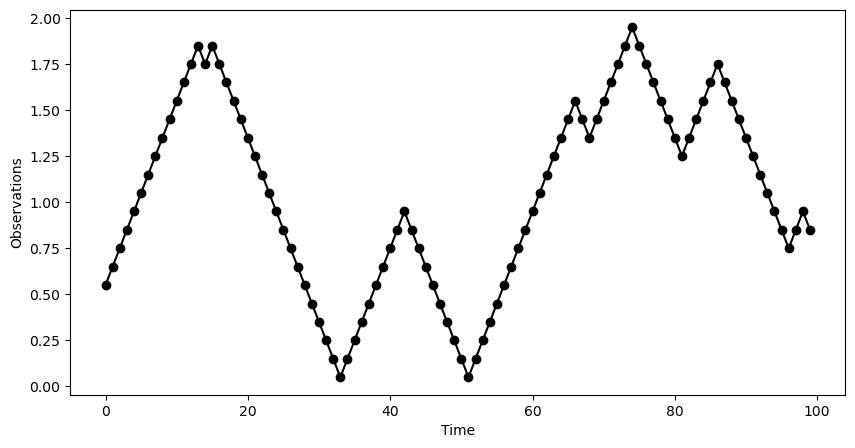

In [140]:
NSteps = 100
NTraj = 250

rate = 0.1
mplus = 0.1
mminus = -0.1
dt = 1
y0 = 1

observations = ObsModels.LinearRamps(NTraj, NSteps, rate, mplus, mminus, dt, initial_seed = 0)

features = []

for i in range(NTraj):
    features.append(np.array([np.ones(NSteps), observations[i]]))


fig, ax = plt.subplots(1,1, figsize=(10,5))
ax.plot(observations[0], 'o', label='Trajectory 0', color='black')
plt.plot(observations[0], color='black', label='Trajectory 0')
ax.set_xlabel('Time')
ax.set_ylabel('Observations')

plt.show()

In [141]:
A = 3
F = 2
M = 4

np.random.seed(0)

Theta = np.random.rand(F, M, M, A)
Psi = np.random.rand(M)

In [142]:
FSC = GenerationContinuousObs(Theta, Psi)
FSC.load_features(features)

In [143]:
trajectories = FSC.generate_trajectories(NSteps = NSteps)
Time = np.arange(NSteps)

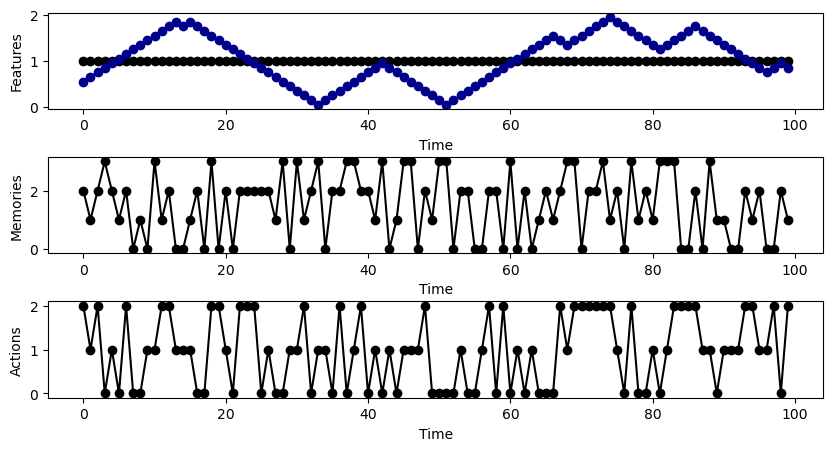

In [144]:
colors = ["k", "darkblue"]
idx_trj = 0
trj = trajectories[idx_trj]
fig, ax = FSC.plot_trajectory(trj, Time, colors_features = colors)

In [ ]:
test._nb_generate_trajectories_parallel(test._nb_get_TMat, len(features), NSteps, test.MemSpace, MASpace, Theta, test.rho, features)

(array([[1, 2, 1, 0, 1, 0, 0, 0, 2, 1, 2, 0, 2, 0, 1, 0, 2, 2, 2, 1, 2, 0,
         2, 2, 0, 0, 2, 0, 2, 1, 0, 1, 0, 1, 0, 1, 0, 1, 2, 0, 0, 1, 0, 2,
         2, 1, 2, 1, 1, 0, 2, 2, 2, 1, 1, 0, 2, 2, 0, 2, 2, 0, 1, 0, 2, 0,
         2, 2, 1, 2, 2, 0, 1, 0, 0, 2, 1, 0, 0, 2, 2, 2, 0, 1, 2, 0, 2, 2,
         2, 1, 2, 0, 2, 2, 1, 1, 2, 1, 0, 2],
        [2, 2, 2, 1, 0, 2, 2, 2, 2, 1, 0, 0, 0, 2, 1, 0, 1, 0, 1, 0, 1, 1,
         0, 1, 0, 1, 1, 1, 2, 0, 2, 1, 2, 1, 0, 0, 2, 1, 0, 1, 0, 1, 0, 2,
         0, 0, 2, 2, 0, 0, 1, 0, 0, 0, 2, 0, 1, 2, 2, 0, 2, 1, 2, 0, 2, 0,
         2, 1, 0, 2, 1, 2, 1, 2, 2, 0, 0, 1, 1, 2, 0, 0, 2, 2, 1, 1, 2, 2,
         0, 2, 2, 2, 2, 1, 2, 0, 0, 0, 0, 2],
        [0, 1, 1, 0, 0, 2, 1, 1, 0, 1, 0, 2, 0, 0, 0, 0, 1, 0, 1, 2, 1, 0,
         1, 0, 1, 0, 1, 1, 0, 0, 0, 2, 0, 1, 2, 0, 0, 0, 1, 0, 2, 2, 2, 0,
         2, 2, 2, 2, 0, 0, 1, 0, 1, 2, 0, 0, 2, 0, 0, 0, 2, 2, 0, 1, 0, 0,
         1, 2, 2, 0, 1, 1, 2, 0, 0, 0, 1, 1, 0, 2, 1, 0, 0, 2, 1, 0, 0, 0,
        